# Desafio 5: Modelagem de Dados #

## Apresentação: ##

Neste Desafio, o objetivo é fazer a modelagem de dados do Dataset recebido do nosso e-commerce e levantar os indicadores de RFM.
Para entrega, vamos preparar um csv com a identificação do cliente e as métricas RFM.

RFM:

**R (Recency):** Tempo que o cliente realizou a última compra (em dias)

**F (Frequency):** Quantidade de compras realizadas pelo cliente

**M (Monetary):** Valor do ticket médio gasto pelo cliente
onde ticket médio = média do total gasto por pedido para cada cliente


## 0 - Importando as bibliotecas ##

In [1]:
!pip install pandas-profiling==3.3.0

In [136]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import datetime as dt

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import scale, StandardScaler, OneHotEncoder, OrdinalEncoder

In [3]:
from sklearn import set_config
set_config(display='diagram')

In [4]:
# Configurando o tema dos gráficos do Seaborn
sns.set_theme(
    context='talk',
    style='ticks',
    font_scale=.8,
    rc={
        'figure.figsize': (12,8)
    }
)

## 1 - Leitura e Inspeção de dados ##

In [5]:
# Função de importar arquivo para o colab
from google.colab import files
upload = files.upload()

Saving data.csv to data.csv


In [29]:
# Carregando os dados
dados = pd.read_csv('data.csv', sep = ',',  encoding= 'unicode_escape')

In [9]:
display(dados)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


In [10]:
dados.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [11]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


## 2 Valores Faltantes ##

In [45]:
dados.isna().sum().sort_values(ascending = False)

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [44]:
dados = dados.dropna()

## 3 - Preços unitários e quantidade de produtos iguais ou inferior a 0 ##


In [47]:
dados.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [49]:
dados.query('UnitPrice <= 0')

In [53]:
dados.query('Quantity <= 0')

In [55]:
dados = dados.query('UnitPrice > 0 & Quantity > 0')

## 4 - Linhas Duplicadas ##

In [69]:
duplicadas = dados[dados.duplicated() == True]
dados = dados.drop(duplicadas.index, axis = 0)

In [70]:
dados[dados.duplicated() == True]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


## 5 - Convertendo os dados das colunas ##

In [72]:
dados['CustomerID'] = dados['CustomerID'].astype(int)

In [75]:
dados['InvoiceDate'] = pd.to_datetime(dados['InvoiceDate'], format='%m/%d/%Y %H:%M:%S')

In [77]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392692 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392692 non-null  object        
 1   StockCode    392692 non-null  object        
 2   Description  392692 non-null  object        
 3   Quantity     392692 non-null  int64         
 4   InvoiceDate  392692 non-null  datetime64[ns]
 5   UnitPrice    392692 non-null  float64       
 6   CustomerID   392692 non-null  int64         
 7   Country      392692 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 27.0+ MB


## 6 - Tratando Outliers ##

In [ ]:
dados.query('Quantity > 10000 | UnitPrice > 5000')

In [81]:
dados = dados.query('Quantity < 10000 | UnitPrice < 5000')

## 7 - Colunas Adicionais ##

In [82]:
dados['Total'] = dados['Quantity'] * dados['UnitPrice']
dados.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


## 8 - Última data de compra ##

In [83]:
ultima_compra = dados['InvoiceDate'].max()
ultima_compra

Timestamp('2011-12-09 12:50:00')

## 9 - Visualização Gráfica ##

In [100]:
# Top 10 Paises com maior valor em Vendas
top_paises = dados[['Country', 'Total']]
top_paises = top_paises.groupby(['Country']).sum().sort_values(by = 'Total', ascending = True)
top_paises = top_paises.head(10)

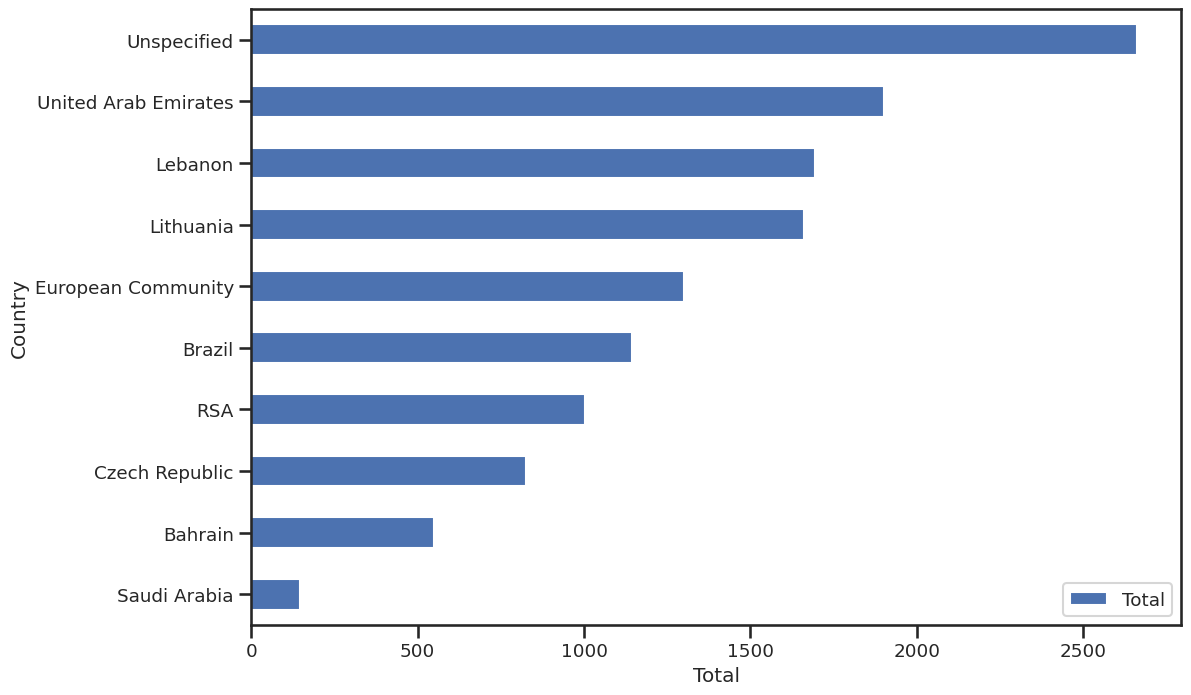

In [101]:
top_paises.plot.barh(figsize=(12,8))
plt.xlabel('Total')
plt.show()

In [118]:
# Top 10 produtos mais vendidos
top_produtos = dados[['Description']]
top_produtos = top_produtos.value_counts()
#top_produtos.groupby(['Description']).count().sort_values(by = 'Quantity', ascending = True)
top_produtos = top_produtos.head(10)

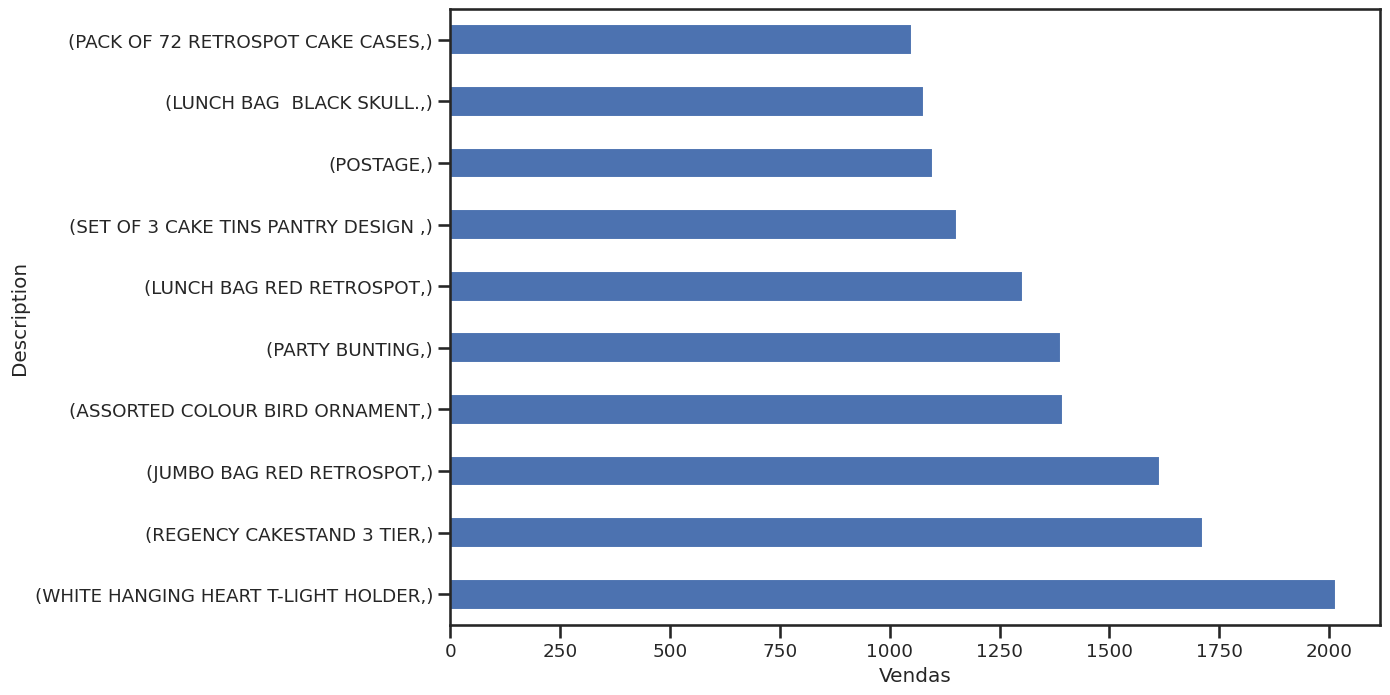

In [119]:
top_produtos.plot.barh(figsize=(12,8))
plt.xlabel('Vendas')
plt.show()

In [125]:
# Valor de venda total por mês
vendas_mes = dados[['InvoiceDate','Total']]
vendas_mes['InvoiceDate'] =  vendas_mes['InvoiceDate'].dt.date
vendas_mes = vendas_mes.groupby(['InvoiceDate']).sum('Total')
vendas_mes.head()

<ipython-input-125-9f55845f9804>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vendas_mes['InvoiceDate'] =  vendas_mes['InvoiceDate'].dt.date


,Total
InvoiceDate,
2010-12-01,46192.49
2010-12-02,47197.57
2010-12-03,23876.63
2010-12-05,31361.28
2010-12-06,31009.33


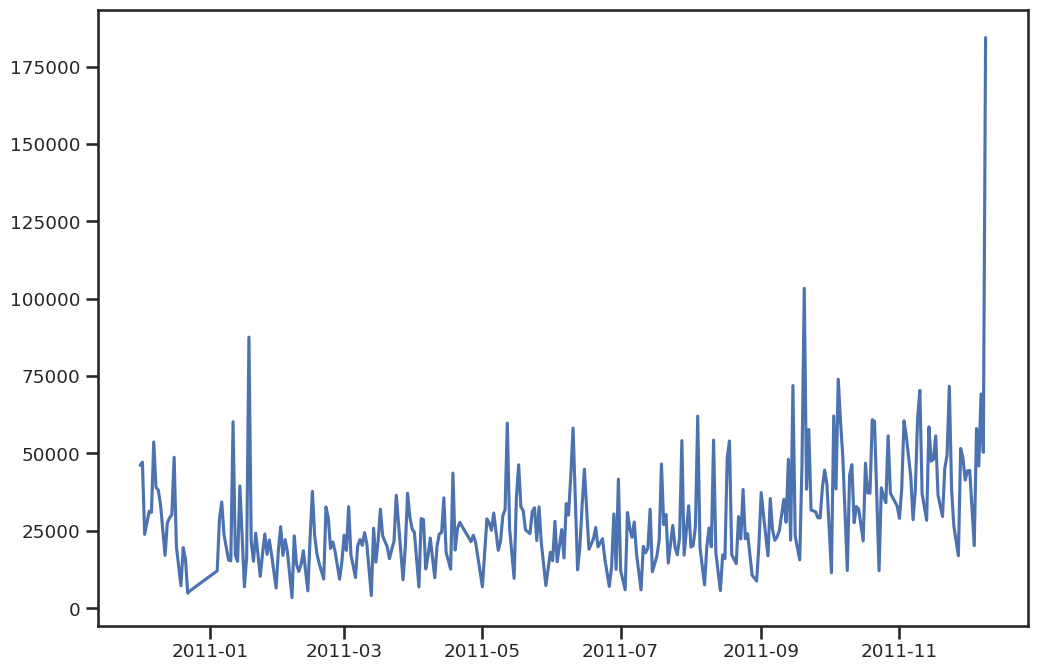

In [126]:

plt.plot(vendas_mes)
plt.show()

In [127]:
# Valor de venda total por mês e por país

vendas_mes_pais = dados[['InvoiceDate', 'Country','Total']]
vendas_mes_pais['InvoiceDate'] =  vendas_mes_pais['InvoiceDate'].dt.date
vendas_mes_pais = vendas_mes_pais.groupby(['InvoiceDate', 'Country']).sum('Total')
vendas_mes_pais = vendas_mes_pais.head(10)
vendas_mes_pais

<ipython-input-127-fc977eee5d52>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vendas_mes_pais['InvoiceDate'] =  vendas_mes_pais['InvoiceDate'].dt.date


Total
InvoiceDate Country                 
2010-12-01  Australia         358.25
            EIRE              555.38
            France            855.86
            Germany           261.48
            Netherlands       192.60
            Norway           1919.14
            United Kingdom  42049.78
2010-12-02  EIRE               22.50
            Germany           155.35
            United Kingdom  47019.72

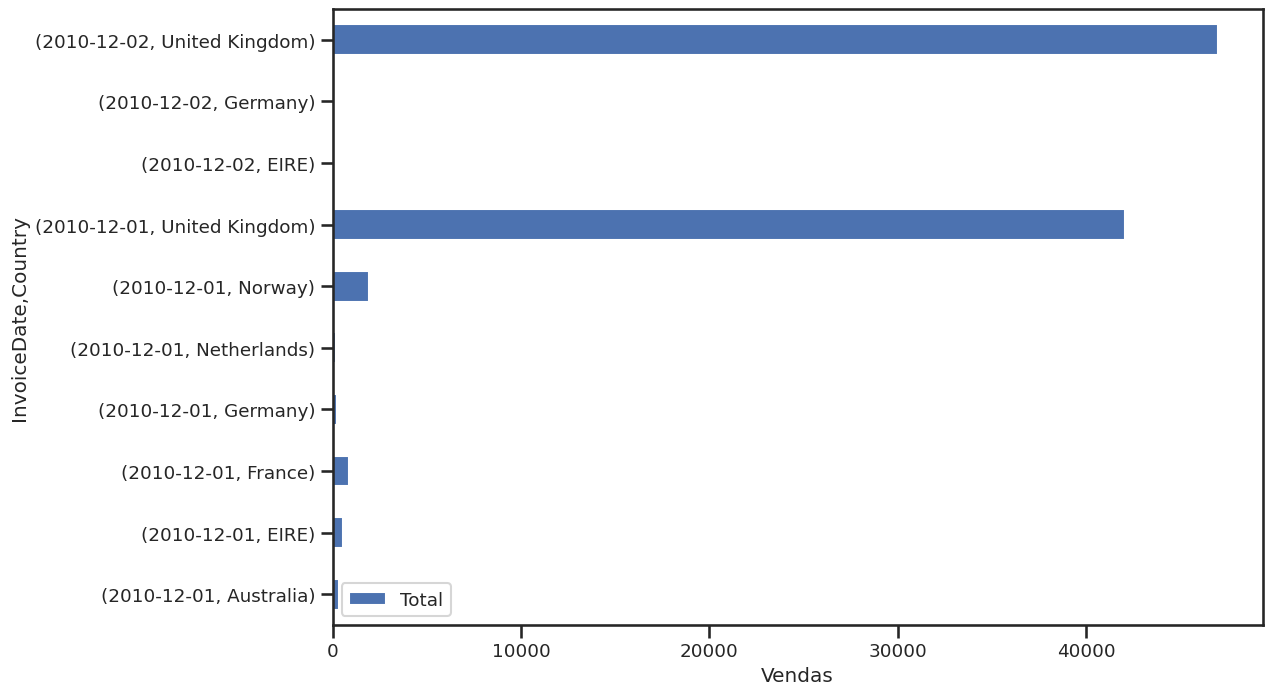

In [129]:
vendas_mes_pais.plot.barh(figsize=(12,8))
plt.xlabel('Vendas')
plt.show()

## 10 - Cálculo de RFM ##

In [84]:
dados.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'Total'],
      dtype='object')

In [133]:
rfm = dados[['CustomerID', 'InvoiceNo', 'InvoiceDate', 'Total']]
rfm.groupby(['CustomerID', 'InvoiceDate']).sum('Total')

Total
CustomerID InvoiceDate                  
12346      2011-01-18 10:01:00  77183.60
12347      2010-12-07 14:57:00    711.79
           2011-01-26 14:30:00    475.39
           2011-04-07 10:43:00    636.25
           2011-06-09 13:01:00    382.52
...                                  ...
18283      2011-11-30 12:59:00    220.31
           2011-12-06 12:02:00    208.00
18287      2011-05-22 10:39:00    765.28
           2011-10-12 10:23:00   1001.32
           2011-10-28 09:29:00     70.68

[18440 rows x 1 columns]

In [142]:
rfm = dados.groupby(['CustomerID']).agg({'InvoiceDate': lambda x : (ultima_compra - x.max()).days, 'InvoiceNo':'count','Total': 'mean'})
# Renomeando as colunas, pois elas são criadas com os nomes originais e não das métricas
rfm = rfm.rename(columns={'InvoiceDate':'Recência','InvoiceNo':'Frequência','Total':'ValorMonetario'})

In [143]:
rfm

,Recência,Frequência,ValorMonetario
CustomerID,,,
12346,325,1,77183.600000
12347,1,182,23.681319
12348,74,31,57.975484
12349,18,73,24.076027
12350,309,17,19.670588
...,...,...,...
18280,277,10,18.060000
18281,180,7,11.545714
18282,7,12,14.837500


In [145]:
rfm.to_csv("rfm.csv", sep =';')